# OLG model

**Table of contents**<a id='toc0_'></a>    
- 1. [Model description](#toc1_)    
  - 1.1. [Solution and simulation](#toc1_1_)    
  - 1.2. [Test case](#toc1_2_)    
  - 1.3. [Simulate first period manually](#toc1_3_)    
  - 1.4. [Full simulation](#toc1_4_)    
- 2. [Active government](#toc2_)    
- 3. [Potential analysis and extensions](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

You will learn how to solve the **overlapping generations (OLG) model**.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# models
from OLGModel import OLGModelClass

## 1. <a id='toc1_'></a>[Model description](#toc0_)

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Population is constant. A life consists of
two periods, *young* and *old*.

**Households:** As young a household supplies labor exogenously, $N_{t}=1$, and earns a after tax wage $(1-\tau_w)w_{t}N_{t}$.<br>
Consumption as young and old are denoted by $C_{1t}$ and $C_{2t+1}$. The after-tax return on saving is $(1-\tau_{r})r_{t+1}$.<br>
Utility is
    
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1]}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\beta\frac{C_{2t+1}^{1-\sigma}}{1-\sigma},\,\,\,\beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}(1-\tau_{w})w_{t}N_{t}\\
 & C_{1t}=(1-s_{t})(1-\tau_{w})w_{t}N_{t}\\
 & C_{2t+1}=(1+(1-\tau_{r})r_{t+1})S_{t}
\end{aligned}
$$
    
The problem is formulated in terms of the saving rate $s_t\in[0,1]$.

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$,
and hires labor $L_{t}$ at the wage rate $w_{t}$. Firms have access
to the production function
    
$$
\begin{aligned}
Y_{t}=F(K_{t-1},L_{t})=(\alpha K_{t-1}^{-\theta}+(1-\alpha)L_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1)
\end{aligned}
$$
    
Profits are
    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}L_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Government:** Choose public consumption, $G_{t}$, and tax rates $\tau_w \in [0,1]$ and $\tau_r \in [0,1]$. Total tax revenue is
    
$$
\begin{aligned}
T_{t} &=\tau_r r_{t} (K_{t-1}+B_{t-1})+\tau_w w_{t}N_{t}   
\end{aligned}
$$
    
Government debt accumulates according to
    
$$
\begin{aligned}
B_{t} &=(1+r^b_{t})B_{t-1}-T_{t}+G_{t} 
\end{aligned}
$$
       
A *balanced budget* implies $G_{t}=T_{t}-r_{t}B_{t-1}$.

**Capital:** Depreciates with a rate of $\delta \in [0,1]$.

**Equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. No-arbitrage between bonds and capital

    $$
    r_{t}=r_{t}^{K}-\delta=r_{t}^{b}
    $$

4. Labor market clears: $L_{t}=N_{t}=1$
5. Goods market clears: $Y_{t}=C_{1t}+C_{2t}+G_{t}+I_{t}$
6. Asset market clears: $S_{t}=K_{t}+B_{t}$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

**For more details on the OLG model:** See chapter 3-4 [here](https://web.econ.ku.dk/okocg/VM/VM-general/Material/Chapters-VM.htm).

### 1.1. <a id='toc1_1_'></a>[Solution and simulation](#toc0_)

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t}^{k} & =F_{K}(K_{t-1},L_{t})=\alpha K_{t-1}^{-\theta-1}Y_{t}^{1+\theta}\\
w_{t} & =F_{L}(K_{t-1},L_{t})=(1-\alpha)L_{t}^{-\theta-1}Y_{t}^{1+\theta}
\end{aligned}
$$

**Implication of utility maximization:** From FOC

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta (1+(1-\tau_r)r_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

**Simulation algorithm:** At the beginning of period $t$, the
economy can be summarized in the state variables $K_{t-1}$ and $B_{t-1}$.<br>
*Before* $s_t$ is known, we can calculate:

$$
\begin{aligned}
Y_{t} & =F(K_{t-1},1)\\
r_{t}^{k} & =F_{K}(K_{t-1},1)\\
w_{t} & =F_{L}(K_{t-1},1)\\
r_{t} & =r^k_{t}-\delta\\
r_{t}^{b} & =r_{t}\\
\tilde{r}_{t} & =(1-\tau_{r})r_{t}\\
C_{2t} & =(1+\tilde{r}_{t})(K_{t-1}+B_{t-1})\\
T_{t} & =\tau_{r}r_{t}(K_{t-1}+B_{t-1})+\tau_{w}w_{t}\\
B_{t} & =(1+r^b_{t})B_{t-1}+T_{t}-G_{t}\\
\end{aligned}
$$

*After* $s_t$ is known we can calculate:

$$
\begin{aligned}
C_{1t} & = (1-s_{t})(1-\tau_{w})w_{t}\\
I_{t} & =Y_{t}-C_{1t}-C_{2t}-G_{t}\\
K_{t} & =(1-\delta)K_{t-1} + I_t
\end{aligned}
$$

**Solution algorithm:** Simulate forward choosing $s_{t}$ so
that we always have

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta(1+\tilde{r}_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

**Implementation:**

1. Use a bisection root-finder to determine $s_t$
2. Low $s_t$: A lot of consumption today. Low marginal utility. LHS < RHS.
3. High $s_t$: Little consumption today. High marginal utility. LHS > RHS.
4. Problem: Too low $s_t$ might not be feasible if $B_t > 0$.

**Note:** Never errors in the Euler-equation due to *perfect foresight*.

**Question:** Are all the requirements for the equilibrium satisfied?

### 1.2. <a id='toc1_2_'></a>[Test case](#toc0_)

1. Production is Cobb-Douglas ($\theta = 0$)
2. Utility is logarithmic ($\sigma = 1$)
3. The government is not doing anything ($\tau_w=\tau_r=0$, $T_t = G_t = 0$ and $B_t = 0$) 

**Analytical steady state:** It can be proven

$$ \lim_{t\rightarrow\infty} K_t = \left(\frac{1-\alpha}{1+1/\beta}\right)^{\frac{1}{1-\alpha}} $$

**Setup:**

In [2]:
model = OLGModelClass()
par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace

# a. production
par.production_function = 'cobb-douglas'
par.theta = 0.0

# b. households
par.sigma = 1.0

# c. government
par.tau_w = 0.0
par.tau_r = 0.0
sim.balanced_budget[:] = True # G changes to achieve this

# d. initial values
K_ss = ((1-par.alpha)/((1+1.0/par.beta)))**(1/(1-par.alpha))
par.K_lag_ini = 0.1*K_ss

initializing the model:
calling .setup()
calling .allocate()


### 1.3. <a id='toc1_3_'></a>[Simulate first period manually](#toc0_)

In [3]:
from OLGModel import simulate_before_s, simulate_after_s, find_s_bracket, calc_euler_error

**Make a guess:**

In [4]:
s_guess = 0.41

**Evaluate first period:**

In [5]:
# a. initialize
sim.K_lag[0] = par.K_lag_ini
sim.B_lag[0] = par.B_lag_ini

simulate_before_s(par,sim,t=0)
print(f'{sim.C2[0] = : .4f}')

simulate_after_s(par,sim,s=s_guess,t=0)
print(f'{sim.C1[0] = : .4f}')

simulate_before_s(par,sim,t=1)
print(f'{sim.C2[1] = : .4f}')
print(f'{sim.rt[1] = : .4f}')

LHS_Euler = sim.C1[0]**(-par.sigma)
RHS_Euler = (1+sim.rt[1])*par.beta * sim.C2[1]**(-par.sigma)
print(f'euler-error = {LHS_Euler-RHS_Euler:.8f}')

sim.C2[0] =  0.0973
sim.C1[0] =  0.1221
sim.C2[1] =  0.1855
sim.rt[1] =  1.1871
euler-error = -0.22834540


**Implemented as function:**

In [6]:
euler_error = calc_euler_error(s_guess,par,sim,t=0)
print(f'euler-error = {euler_error:.8f}')

euler-error = -0.22834540


**Find bracket to search in:**

In [7]:
s_min,s_max = find_s_bracket(par,sim,t=0,do_print=True);

euler-error for s =   0.99999999 = 483321577.17005599
euler-error for s =   0.50000000 =   2.76183762
euler-error for s =   0.25000001 =  -7.36489999
bracket to search in with opposite signed errors:
[  0.25000001-  0.50000000]


**Call root-finder:**

In [8]:
obj = lambda s: calc_euler_error(s,par,sim,t=0)
result = optimize.root_scalar(obj,bracket=(s_min,s_max),method='bisect')
print(result)

      converged: True
           flag: 'converged'
 function_calls: 39
     iterations: 37
           root: 0.41666666666653274


**Check result:**

In [9]:
euler_error = calc_euler_error(result.root,par,sim,t=0)
print(f'euler-error = {euler_error:.8f}')

euler-error = -0.00000000


### 1.4. <a id='toc1_4_'></a>[Full simulation](#toc0_)

In [10]:
model.simulate()

simulation done in 0.02 secs


**Check euler-errors:**

In [11]:
for t in range(5):
    LHS_Euler = sim.C1[t]**(-par.sigma)
    RHS_Euler = (1+sim.rt[t+1])*par.beta * sim.C2[t+1]**(-par.sigma)
    print(f't = {t:2d}: euler-error = {LHS_Euler-RHS_Euler:.8f}')

t =  0: euler-error = -0.00000000
t =  1: euler-error = -0.00000000
t =  2: euler-error = -0.00000000
t =  3: euler-error = -0.00000000
t =  4: euler-error = -0.00000000


**Plot and check with analytical solution:**

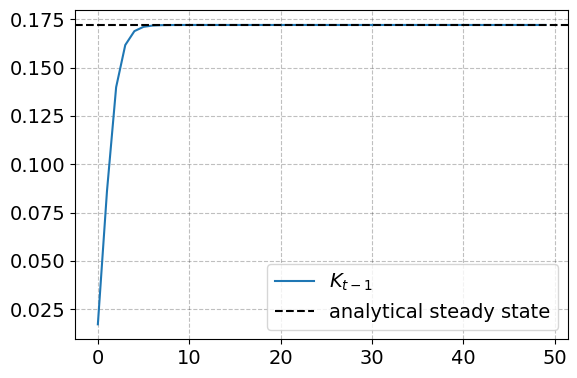

In [12]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.K_lag,label=r'$K_{t-1}$')
ax.axhline(K_ss,ls='--',color='black',label='analytical steady state')
ax.legend(frameon=True)
fig.tight_layout()
K_lag_old = model.sim.K_lag.copy()

**Task:** Test if the starting point matters?

**Additional check:** Not much should change with only small parameter changes. 

In [13]:
# a. production (close to cobb-douglas)
par.production_function = 'ces'
par.theta = 0.001

# b. household (close to logarithmic)
par.sigma = 1.1

# c. goverment (weakly active)
par.tau_w = 0.001
par.tau_r = 0.001

# d. simulate
model.simulate()

simulation done in 0.03 secs


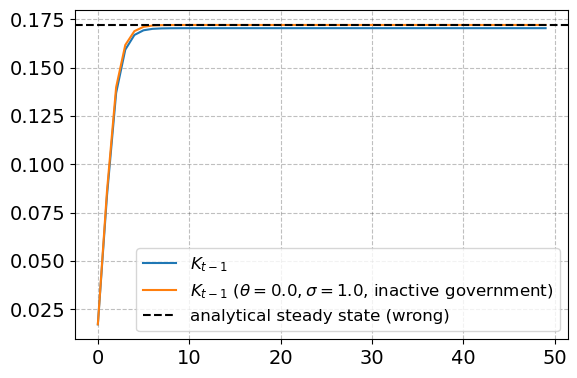

In [14]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.K_lag,label=r'$K_{t-1}$')
ax.plot(K_lag_old,label=r'$K_{t-1}$ ($\theta = 0.0, \sigma = 1.0$, inactive government)')
ax.axhline(K_ss,ls='--',color='black',label='analytical steady state (wrong)')
ax.legend(frameon=True,fontsize=12)
fig.tight_layout()

## 2. <a id='toc2_'></a>[Active government](#toc0_)

In [15]:
model = OLGModelClass()
par = model.par
sim = model.sim

initializing the model:
calling .setup()
calling .allocate()


**Baseline:**

In [16]:
model.simulate()

simulation done in 0.03 secs


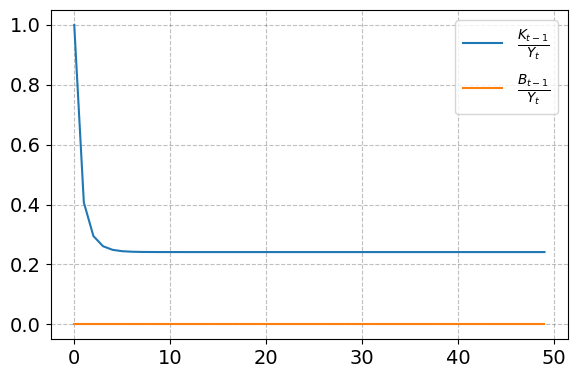

In [17]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(sim.K_lag/(sim.Y),label=r'$\frac{K_{t-1}}{Y_t}$')
ax.plot(sim.B_lag/(sim.Y),label=r'$\frac{B_{t-1}}{Y_t}$')
ax.legend(frameon=True)
fig.tight_layout()

**Remember steady state:**

In [18]:
K_ss = sim.K_lag[-1]
B_ss = sim.B_lag[-1]
G_ss = sim.G[-1]

**Spending spree of 5% in $T=3$ periods:**

In [19]:
# a. start from steady state
par.K_lag_ini = K_ss
par.B_lag_ini = B_ss

# b. spending spree
J = 0
dT = 3
sim.G[J:J+dT] = 1.05*G_ss
sim.balanced_budget[:J] = True #G adjusts
sim.balanced_budget[J:J+dT] = False # B adjusts
sim.balanced_budget[J+dT:] = True # G adjusts

**Simulate:**

In [20]:
model.simulate()

simulation done in 0.03 secs


**Crowding-out of capital:**

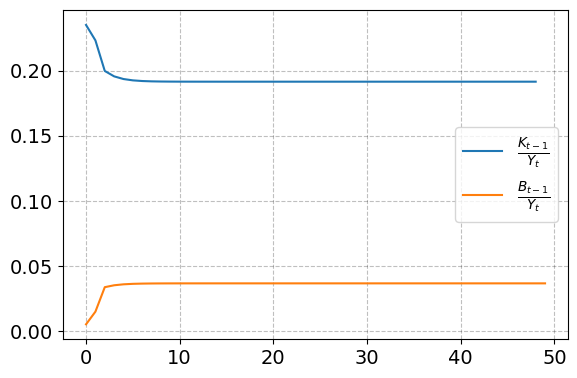

In [21]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(sim.K/(sim.Y),label=r'$\frac{K_{t-1}}{Y_t}$')
ax.plot(sim.B/(sim.Y),label=r'$\frac{B_{t-1}}{Y_t}$')
ax.legend(frameon=True)
fig.tight_layout()

**Question:** Would the households react today if the spending spree is say 10 periods in the future? 

## 3. <a id='toc3_'></a>[Potential analysis and extensions](#toc0_)

**Potential analysis:**

1. Over-accumulation of capital relative to golden rule?
2. Calibration to actual data
3. Generational inequality
4. Multiple equilibria

**Extensions:**

1. Add population and technology growth
2. More detailed tax and transfer system
3. Utility and productive effect of government consumption/investment
4. Endogenous labor supply
5. Bequest motive
6. Uncertain returns on capital
7. Additional assets (e.g. housing)
8. More than two periods in the life-cycle (life-cycle)
9. More than one dynasty (cross-sectional inequality dynamics)